## Machine Learning
### Weather Dataset
Dataset Source: https://www.kaggle.com/datasets/muthuj7/weather-dataset

## IMPORTS
The code imports necessary libraries such as NumPy, pandas, seaborn, and matplotlib for data manipulation, visualization, and plotting. 
It imports scikit-learn, tensorflow and keras modules for building machine learning models. 
It imports evaluation metrics to assess model performance. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For Preprocessing
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# For ML Models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import TensorBoard

In [2]:
# Convert .CSV file into a DataFrame named dataset.
dataset = pd.read_csv("weatherHistory.csv")
# Duplicated rows are removed, keeping only the unique rows, to avoid biasness.
dataset = dataset.drop_duplicates()
# Suffling the dataset, for better distribution.
dataset = dataset.sample(frac=1).reset_index(drop=True).copy()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96429 entries, 0 to 96428
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96429 non-null  object 
 1   Summary                   96429 non-null  object 
 2   Precip Type               95912 non-null  object 
 3   Temperature (C)           96429 non-null  float64
 4   Apparent Temperature (C)  96429 non-null  float64
 5   Humidity                  96429 non-null  float64
 6   Wind Speed (km/h)         96429 non-null  float64
 7   Wind Bearing (degrees)    96429 non-null  float64
 8   Visibility (km)           96429 non-null  float64
 9   Loud Cover                96429 non-null  float64
 10  Pressure (millibars)      96429 non-null  float64
 11  Daily Summary             96429 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [3]:
dataset.isnull().sum() * 100 / len(dataset)
# Very low % of data is missing, just drop them.

Formatted Date              0.000000
Summary                     0.000000
Precip Type                 0.536146
Temperature (C)             0.000000
Apparent Temperature (C)    0.000000
Humidity                    0.000000
Wind Speed (km/h)           0.000000
Wind Bearing (degrees)      0.000000
Visibility (km)             0.000000
Loud Cover                  0.000000
Pressure (millibars)        0.000000
Daily Summary               0.000000
dtype: float64

# Encoding "Precip Type" column 
The simplest way to encode 'Precip Type' as dummy variable is to use the replace method. 

In [4]:
dataset['Precip Type'] = dataset['Precip Type'].replace('snow',0)
dataset['Precip Type'] = dataset['Precip Type'].replace('rain',1)

# Removing the unnecessary features

Daily summary is just description of summary column.
Loud cover is always 0.0 for all the examples in dataset.

In [5]:
dataset['Formatted Date'] = pd.to_datetime(dataset['Formatted Date'], utc=True)
dataset['Month'] = dataset['Formatted Date'].dt.month
dataset = dataset.drop(['Formatted Date', 'Daily Summary', 'Loud Cover'], axis=1)

# Analyzing the co-relation between the features to minimize multicolinearity
The code generates a heatmap using the seaborn library to visualize the correlation between features. The corr() function calculates the pairwise correlation between features. The resulting correlation matrix is then plotted as a heatmap using sns.heatmap(). This helps to understand the relationships and dependencies between different variables in the dataset.

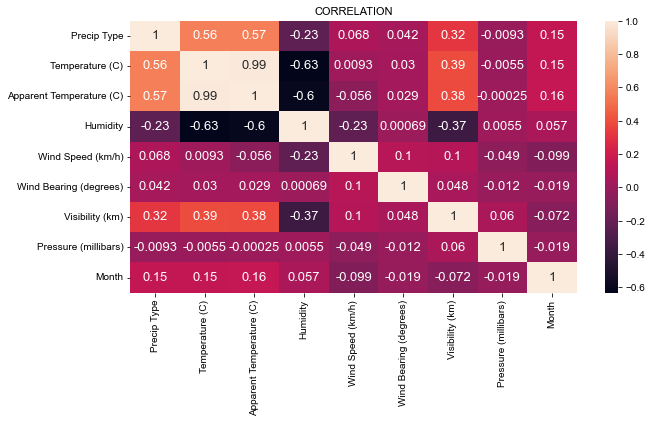

In [6]:
plt.figure(figsize=(10, 5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("CORRELATION", fontsize=11)
sns.heatmap(dataset.corr(),  annot=True, annot_kws={"size": 13})
sns.set_style('white')
plt.show()

Temperature and Apparent Temperature are highly correlated, resulting in biased dataset.
Removing the highly related columns, we aim to reduce the potential bias in the dataset caused by redundancy or multicollinearity between the 'Temperature' and 'Apparent Temperature' features.

In [7]:
dataset = dataset.drop(['Apparent Temperature (C)'], axis=1)

# Checking & Handling Outliers and Data distribution
Each histogram provides a visual representation of the distribution of the features values for a specific variable in the dataset, allowing for an assessment of outliers or unusual patterns. The range of values is determined based on the minimum and the maximum values of each respective column in the dataset.

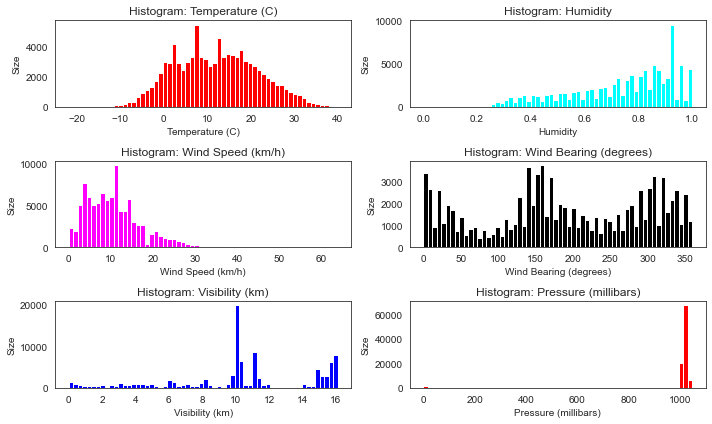

In [8]:
def Data_Distribution():
    columns = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']
    colors = ['red', 'cyan', 'magenta', 'black', 'blue', 'red']

    num_plots = len(columns)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))
    for i, column in enumerate(columns):
        ax = axes[i // num_cols, i % num_cols]
        ax.hist(dataset[column], bins=60, color=colors[i], range=(dataset[column].min(), dataset[column].max()))
        ax.set_xlabel(column, fontsize=10)
        ax.set_ylabel('Size', fontsize=10)
        ax.set_title(f"Histogram: {column}", fontsize=12)
    plt.tight_layout()
    plt.show()
Data_Distribution()

In [9]:
## REMOVING THE OUTLIERS
dataset = dataset[dataset['Temperature (C)'] >= -12.0]
dataset = dataset[dataset['Temperature (C)'] <= 36.5]
dataset = dataset[dataset['Humidity'] >= 0.22]
dataset = dataset[dataset['Wind Speed (km/h)'] < 30.0]
dataset = dataset[dataset['Wind Bearing (degrees)'] < 352.0]
dataset = dataset[dataset['Pressure (millibars)'] >= 985.0]
dataset = dataset[dataset['Pressure (millibars)'] <= 1040.0]
dataset.describe()

,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Month
count,90727.000000,91232.000000,91232.000000,91232.000000,91232.000000,91232.000000,91232.000000,91232.000000
mean,0.891631,12.013760,0.737840,10.422813,183.714344,10.392607,1016.790515,6.529759
std,0.310848,9.415441,0.193568,6.220860,105.866783,4.197372,7.578144,3.431009
min,0.000000,-11.977778,0.220000,0.000000,0.000000,0.000000,985.850000,1.000000
25%,1.000000,4.816667,0.610000,5.699400,110.000000,8.372000,1012.180000,4.000000
50%,1.000000,12.088889,0.790000,9.772700,176.000000,10.046400,1016.560000,7.000000
75%,1.000000,18.844444,0.900000,13.990900,283.000000,14.908600,1021.110000,10.000000
max,1.000000,36.272222,1.000000,29.994300,351.000000,16.100000,1040.000000,12.000000


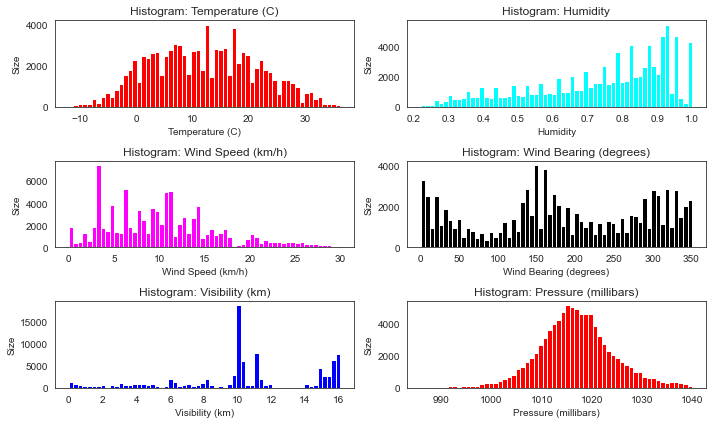

In [10]:
Data_Distribution()

# Analyzing Target Column: Summary

In [11]:
print(dataset['Summary'].value_counts())

Partly Cloudy               30787
Mostly Cloudy               27424
Overcast                    15953
Clear                        9812
Foggy                        6781
Breezy and Overcast            82
Breezy and Mostly Cloudy       70
Light Rain                     63
Dry and Partly Cloudy          58
Breezy and Partly Cloudy       49
Humid and Mostly Cloudy        40
Drizzle                        38
Dry                            18
Humid and Partly Cloudy        17
Dry and Mostly Cloudy          11
Breezy                         11
Rain                            9
Humid and Overcast              7
Breezy and Foggy                2
Name: Summary, dtype: int64


In [12]:
# Removing the classes with less number of example rows.
classes_remove=["Breezy and Overcast","Breezy and Mostly Cloudy", "Breezy and Partly Cloudy",
                "Dry and Partly Cloudy","Humid and Mostly Cloudy","Humid and Partly Cloudy", "Breezy", "Dry",
                "Dry and Mostly Cloudy","Light Rain","Rain","Drizzle","Humid and Overcast","Breezy and Foggy"]
dataset=dataset[~dataset["Summary"].isin(classes_remove)]
dataset['Summary']=dataset['Summary'].replace({'Foggy' : 'Overcast'})
dataset.reset_index(drop=True, inplace=True)
print(dataset['Summary'].value_counts())

Partly Cloudy    30787
Mostly Cloudy    27424
Overcast         22734
Clear             9812
Name: Summary, dtype: int64


# Relationship of Summary with Features:
Encoding the 'Summary' column of the dataset into numerical labels. Plotting the boxplots to visualize the relationship between the encoded 'Summary' variable and all other features. Each boxplot shows the distribution of the numerical feature for different categories of the encoded 'Summary' variable.

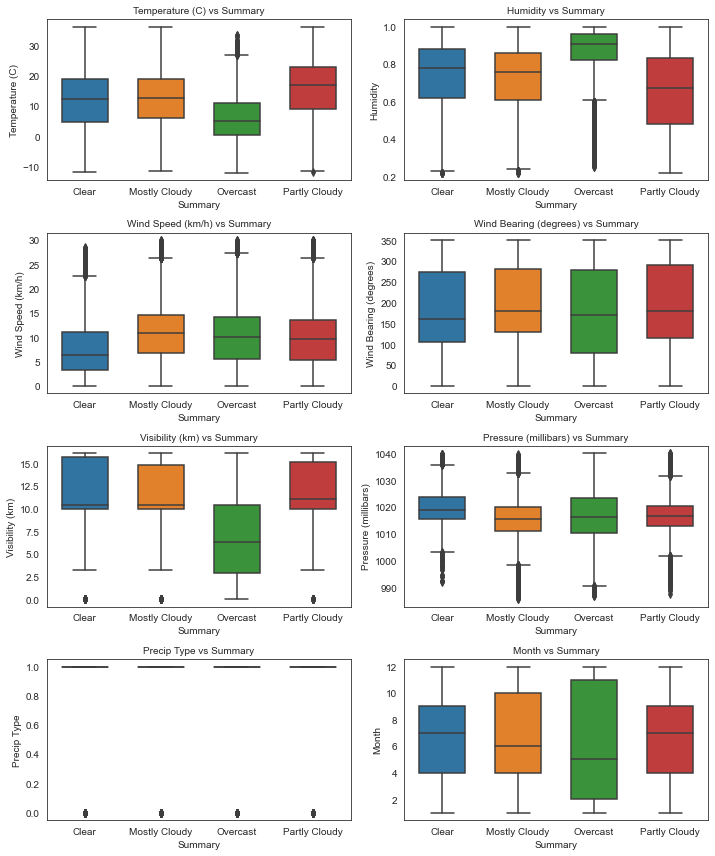

In [13]:
LE = LabelEncoder()
dataset['Summary_Encoded'] = LE.fit_transform(dataset['Summary'])

features=['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
          'Visibility (km)', 'Pressure (millibars)', 'Precip Type', 'Month']
num_plots = len(features)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

# Subplots:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 12))
for i, feature in enumerate(features):
    ax = axes[i // num_cols, i % num_cols]
    sns.boxplot(x=dataset['Summary_Encoded'], y=dataset[feature], ax=ax, width=0.6)
    ax.set_xlabel('Summary', fontsize=10)
    ax.set_ylabel(feature, fontsize=10)
    ax.set_title(f"{feature} vs Summary", fontsize=10)
    ax.set_xticklabels(LE.classes_)
dataset = dataset.drop(['Summary_Encoded'], axis=1)
plt.tight_layout()
plt.show()

### Observation
Feature: 'Precip Type' isn't helping in predicting the output class.

"Partly Cloudy" & "Mostly Cloudy" classes have almost similar feature distribution, as seen in the plots above, its better to merge them into a single class named, "Cloudy".

In [14]:
dataset = dataset.drop(['Precip Type'], axis=1)
dataset['Summary'] = dataset['Summary'].replace({'Partly Cloudy' : 'Cloudy'})
dataset['Summary'] = dataset['Summary'].replace({'Mostly Cloudy' : 'Cloudy'})
dataset.reset_index(drop=True, inplace=True)
print(dataset['Summary'].value_counts())

Cloudy      58211
Overcast    22734
Clear        9812
Name: Summary, dtype: int64


# Normalization
For normalization, scikit-learn's MinMaxScaler function is used to scale selected features in the dataset in between 0 and 1. It applies the scaling transformation to the specified columns using the fit_transform() method.

In [15]:
# Using MinMaxScaler() Method to implement the normalization.
scaler = MinMaxScaler()
columns = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 
           'Visibility (km)', 'Pressure (millibars)', 'Month']
dataset[columns] = scaler.fit_transform(dataset[columns])

# Saving the cleaned dataset
Saving the cleaned dataset to a CSV file, this creates a clear separation between the data cleaning step and modeling steps. This makes the code modular and easier to understand.

Saving the cleaned dataset to a CSV file helps in data management, reproducibility, and ensuring the availability of clean data for future use.

In [16]:
dataset.to_csv('weatherHistoryClean.csv', index=False) #Saving Dataset

In [17]:
dataset = pd.read_csv("weatherHistoryClean.csv")
dataset = dataset.sample(frac=1).reset_index(drop=True).copy()
features = dataset.drop('Summary', axis=1)  # Features
target = dataset['Summary']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=42)

# Non Parametric Algorithm (KNN Classifer):
KNN (K-Nearest Neighbors) is a supervised machine learning algorithm used for both classification and regression tasks. It is a non-parametric and instance-based algorithm that makes predictions based on the similarity of data points.

In KNN, the "K" refers to the number of nearest neighbors considered when making a prediction.

KNN is a versatile algorithm used for various classification and regression tasks, especially when the decision boundary is difficult to express analytically.

### First KNN Algorithm Model with K=3:

In [18]:
knn1 = KNeighborsClassifier(n_neighbors=3)
knn1.fit(X_train, y_train)
# Doing Predictions
knn1_train_predictions = knn1.predict(X_train) # Make predictions on the train data 
knn1_test_predictions  = knn1.predict(X_test) # Make predictions on the train data 

# Evaluate the accuracy of the model on training data
knn1_train_accuracy = accuracy_score(y_train, knn1_train_predictions)
knn1_test_accuracy  = accuracy_score(y_test,  knn1_test_predictions)
print(f'Train Accuracy : {knn1_train_accuracy:0.1%}')
print(f'Test  Accuracy : {knn1_test_accuracy:0.1%}')

Train Accuracy : 86.8%
Test  Accuracy : 75.8%


### Second KNN Algorithm Model with K=5:

In [19]:
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(X_train, y_train)
# Doing Predictions
knn2_train_predictions = knn2.predict(X_train) # Make predictions on the train data 
knn2_test_predictions = knn2.predict(X_test)   # Make predictions on the train data 

# Evaluate the accuracy of the model on training data
knn2_train_accuracy = accuracy_score(y_train, knn2_train_predictions)
knn2_test_accuracy  = accuracy_score(y_test,  knn2_test_predictions)
print(f'Train Accuracy : {knn2_train_accuracy:0.1%}')
print(f'Test  Accuracy : {knn2_test_accuracy:0.1%}')

Train Accuracy : 83.6%
Test  Accuracy : 76.9%


### Third KNN Algorithm Model with K=10:

In [20]:
# Create the KNN classifier with K = 10
knn3 = KNeighborsClassifier(n_neighbors=10)
knn3.fit(X_train, y_train)
# Doing Predictions
knn3_train_predictions = knn3.predict(X_train) # Make predictions on the train data 
knn3_test_predictions = knn3.predict(X_test) # Make predictions on the train data 

# Evaluate the accuracy of the model on training data
knn3_train_accuracy = accuracy_score(y_train, knn3_train_predictions)
knn3_test_accuracy  = accuracy_score(y_test,  knn3_test_predictions)
print(f'Train Accuracy : {knn3_train_accuracy:0.1%}')
print(f'Test  Accuracy : {knn3_test_accuracy:0.1%}')

Train Accuracy : 80.2%
Test  Accuracy : 77.2%


### Comparison of KNN Algorithm Models:

Comparing the three KNN models with different values of K (3, 5, 10) based on their train and test accuracy. It creates a bar graph to visualize the accuracy scores of the models.

Then, calculating performance metrics such as the confusion matrix, recall score, precision score, and F1 score for each model. The confusion matrix provides information about the model's predictions, while the recall score measures its ability to correctly identify positive instances. The precision score measures its ability to correctly identify positive instances out of all predicted positives. The F1 score is a balanced measure that considers both precision and recall.

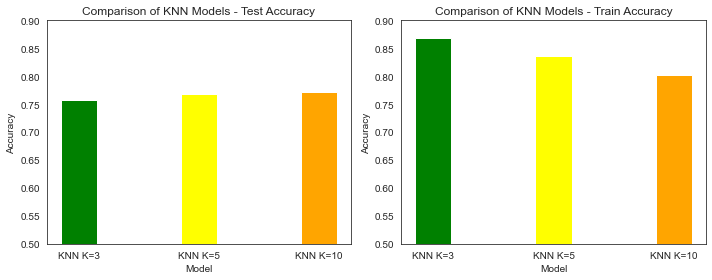

In [21]:
models = ['KNN K=3', 'KNN K=5', 'KNN K=10']
train_scores = [knn1_train_accuracy, knn2_train_accuracy, knn3_train_accuracy]
test_scores = [knn1_test_accuracy, knn2_test_accuracy, knn3_test_accuracy]
colors = ['green', 'yellow', 'orange']
# Plotting the bar graph for test accuracy
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Set the figure size and subplot layout
axes[0].bar(models, test_scores, color=colors, width=0.3)
axes[0].set(xlabel='Model', ylabel='Accuracy', title='Comparison of KNN Models - Test Accuracy')
axes[0].set_ylim(0.5, 0.9)
axes[1].bar(models, train_scores, color=colors, width=0.3)
axes[1].set(xlabel='Model', ylabel='Accuracy', title='Comparison of KNN Models - Train Accuracy')
axes[1].set_ylim(0.5, 0.9)
plt.tight_layout()
plt.show()

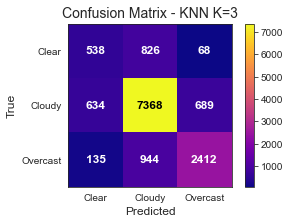

	Recall Score    : 63.81%
	Precision Score : 65.97%
	F1 Score        : 64.87%



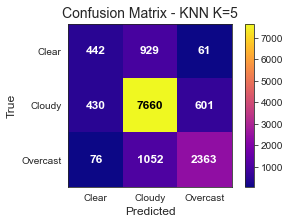

	Recall Score    : 62.23%
	Precision Score : 68.06%
	F1 Score        : 65.02%



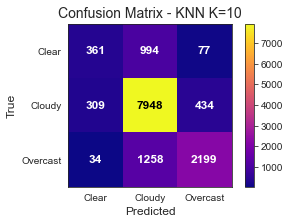

	Recall Score    : 59.88%
	Precision Score : 70.11%
	F1 Score        : 64.60%



In [22]:
for model, knn in zip(models, [knn1, knn2, knn3]):
    #print(f"*** --- {model} --- ***")
    y_pred = knn.predict(X_test)
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    # Plot the confusion matrix with numbers and a different colormap
    plt.figure(figsize=(5, 3))
    plt.imshow(cm, interpolation='nearest', cmap='plasma')
    plt.title(f'Confusion Matrix - {model}', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test))
    plt.yticks(tick_marks, np.unique(y_test))
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            text_color = 'black' if cm[i, j] > cm.max() / 2 else 'white'
            plt.text(j, i, cm[i, j], ha='center', va='center', color=text_color, fontsize=12, weight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.show()
    # RECALL, PRECISION, F1_SCORE
    avg_recall = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    avg_precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
    print(f'\tRecall Score    : {avg_recall:.2%}')
    print(f'\tPrecision Score : {avg_precision:.2%}')
    print(f'\tF1 Score        : {f1_score:.2%}')
    print('')

# Parametric Algorithm (Logistic Regression):
Logistic Regression is a parametric machine learning algorithm used for binary classification. It models the relationship between the input variables (features) and the binary outcome using a logistic function. It is considered a parametric algorithm because it makes certain assumptions about the underlying data distribution.


#### Using multi_class = 'ovr': OneVsAll, to implement multiclass classifcation using logistic regression.

### First Logistic Regression Model  (C=0.1)

In [23]:
# Create an instance of Logistic Regression with C=0.1
logreg1 = LogisticRegression(C=0.1, multi_class='ovr', class_weight='balanced')
logreg1.fit(X_train, y_train)
# Doing Predictions
logreg1_train_predictions = logreg1.predict(X_train)
logreg1_test_predictions  = logreg1.predict(X_test)

# Evaluate the accuracy of the model on training data
logreg1_train_accuracy = accuracy_score(y_train, logreg1_train_predictions)
logreg1_test_accuracy  = accuracy_score(y_test,logreg1_test_predictions)
print(f'Train Accuracy : {logreg1_train_accuracy:0.1%}')
print(f'Test  Accuracy : {logreg1_test_accuracy:0.1%}')

Train Accuracy : 60.7%
Test  Accuracy : 60.6%


### Second Logistic Regression Model (C=0.01)

In [24]:
# Create an instance of Logistic Regression with C=0.01
logreg2 = LogisticRegression(C=0.01, multi_class='ovr',solver='sag', penalty='l2')
logreg2.fit(X_train, y_train)
# Doing Predictions
logreg2_train_predictions = logreg2.predict(X_train)
logreg2_test_predictions  = logreg2.predict(X_test)

# Evaluate the accuracy of the model on training data
logreg2_train_accuracy = accuracy_score(y_train, logreg2_train_predictions)
logreg2_test_accuracy  = accuracy_score(y_test,logreg2_test_predictions)
print(f'Train Accuracy : {logreg2_train_accuracy:0.1%}')
print(f'Test  Accuracy : {logreg2_test_accuracy:0.1%}')

Train Accuracy : 72.8%
Test  Accuracy : 72.8%


### Third Logistic Regression Model: (C=5)

In [25]:
# Create an instance of Logistic Regression with C=5
logreg3 = LogisticRegression(C=5, multi_class='ovr', penalty='l2')
logreg3.fit(X_train, y_train)
# Doing Predictions
logreg3_train_predictions = logreg3.predict(X_train)
logreg3_test_predictions  = logreg3.predict(X_test)

# Evaluate the accuracy of the model on training data
logreg3_train_accuracy = accuracy_score(y_train, logreg3_train_predictions)
logreg3_test_accuracy  = accuracy_score(y_test,logreg3_test_predictions)
print(f'Train Accuracy : {logreg3_train_accuracy:0.1%}')
print(f'Test  Accuracy : {logreg3_test_accuracy:0.1%}')

Train Accuracy : 72.8%
Test  Accuracy : 72.8%


### Comparison of Logistic Regression Algorithm Models:

Comparing the three Logistic Regression models with different values of C (0.1, 0.01, 5) based on their train and test accuracy. It creates a bar graphs to visualize the accuracy scores of the models.

Then, calculating performance metrics such as the confusion matrix, recall score, precision score, and F1 score for each model. The confusion matrix provides information about the model's predictions, while the recall score measures its ability to correctly identify positive instances. The precision score measures its ability to correctly identify positive instances out of all predicted positives. The F1 score is a balanced measure that considers both precision and recall.

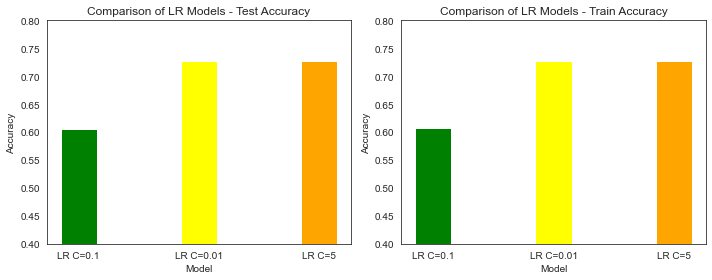

In [26]:
models = ['LR C=0.1', 'LR C=0.01', 'LR C=5']
train_scores = [logreg1_train_accuracy, logreg2_train_accuracy, logreg3_train_accuracy]
test_scores = [logreg1_test_accuracy, logreg2_test_accuracy, logreg3_test_accuracy]
colors = ['green', 'yellow', 'orange']
# Plotting the bar graph for test accuracy
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Set the figure size and subplot layout
axes[0].bar(models, test_scores, color=colors, width=0.3)
axes[0].set(xlabel='Model', ylabel='Accuracy', title='Comparison of LR Models - Test Accuracy')
axes[0].set_ylim(0.4, 0.8)
axes[1].bar(models, train_scores, color=colors, width=0.3)
axes[1].set(xlabel='Model', ylabel='Accuracy', title='Comparison of LR Models - Train Accuracy')
axes[1].set_ylim(0.4, 0.8)
plt.tight_layout()
plt.show()

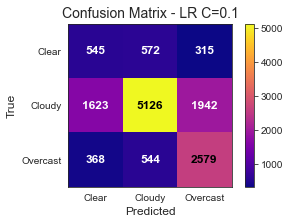

	Recall Score    : 56.97%
	Precision Score : 52.31%
	F1 Score        : 54.54%



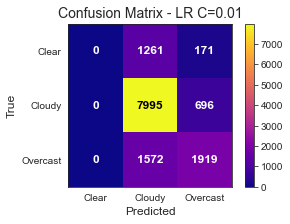

	Recall Score    : 48.99%
	Precision Score : nan%
	F1 Score        : nan%



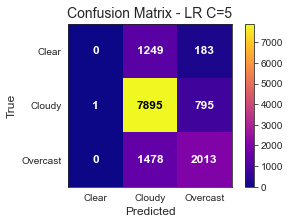

	Recall Score    : 49.50%
	Precision Score : 47.21%
	F1 Score        : 48.33%



In [27]:
for model, logreg in zip(models, [logreg1, logreg2, logreg3]):
    # Predictions
    predictions = logreg.predict(X_test)
    cm = confusion_matrix(y_true=y_test, y_pred=predictions) # Confusion Matrix
    
    # Plot the confusion matrix with numbers and a different colormap
    plt.figure(figsize=(5, 3))
    plt.imshow(cm, interpolation='nearest', cmap='plasma')
    plt.title(f'Confusion Matrix - {model}', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test))
    plt.yticks(tick_marks, np.unique(y_test))
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            text_color = 'black' if cm[i, j] > cm.max() / 2 else 'white'
            plt.text(j, i, cm[i, j], ha='center', va='center', color=text_color, fontsize=12, weight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.show()
    # RECALL, PRECISION, F1_SCORE
    avg_recall = np.mean(np.diag(cm) / np.sum(cm, axis=1)) # Recall Score
    avg_precision = np.mean(np.diag(cm) / np.sum(cm, axis=0)) # Precision Score
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)  # F1 Score    
    # Printing
    print(f'\tRecall Score    : {avg_recall:.2%}')
    print(f'\tPrecision Score : {avg_precision:.2%}')
    print(f'\tF1 Score        : {f1_score:.2%}')
    print('')

# ANN Architecture
Artificial Neural Networks (ANNs) are a type of machine learning model inspired by the biological neural networks in the human brain. ANNs consist of interconnected nodes, called artificial neurons or "units," organized into layers. The architecture of an ANN refers to the arrangement and connectivity of these layers and units. 

### Before Implementing ANN
i.	The LabelEncoder is used to convert categorical target labels into numeric values, enabling the ANN to process them during training.

ii.	The train_test_split function is applied to split the data into training and validation sets (80% training, 20% validation) to evaluate the ANN's performance and prevent overfitting.

iii.	The class_label_mapping is being used in the ANN to decode the numeric predictions into their corresponding class labels. The output is usually a vector of probabilities representing the likelihood of the input belonging to each class.  It is essential for providing human-readable weather summaries as the output of the ANN model instead of dealing with numeric values directly.

In [28]:
# Before implementing ANN.
#Converting Target variable to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

# Split the data into training and validation sets
x_train,X_val,y_train_ann,y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42)

# Store the mapping of class labels to their corresponding numeric values for decoding later
class_label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

### First ANN Model

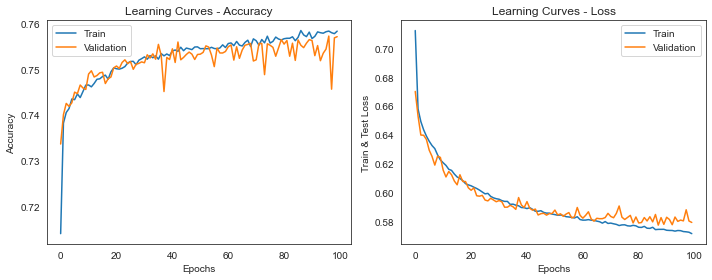

In [29]:
# Define the model architecture
model_1 = Sequential([
    Dense(units=64, input_dim=7, activation='relu', name='hidden_1'),
    Dense(units=32, activation='relu', name='hidden_2'),
    Dense(units=16, activation='relu', name='hidden_3'),
    Dense(units=3, activation='softmax', name='output')
])

model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'], 
                loss_weights=[1.0, 0.0001])

# Set hyperparameters
batch_size = 100
epochs = 100

# Train the model
history_1 = model_1.fit(x_train, 
                        y_train_ann, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        verbose=0, 
                        validation_data=(X_val, y_val))

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Set the figure size and subplot layout
# Plotting the learning curves for train and test accuracy
axes[0].plot(history_1.history['accuracy'], label='Train')
axes[0].plot(history_1.history['val_accuracy'], label='Validation')
axes[0].set(xlabel='Epochs', ylabel='Accuracy', title='Learning Curves - Accuracy')
axes[0].legend()

# Plotting the learning curves for train and test loss
axes[1].plot(history_1.history['loss'], label='Train')
axes[1].plot(history_1.history['val_loss'], label='Validation')
axes[1].set(xlabel='Epochs', ylabel='Train & Test Loss', title='Learning Curves - Loss')
axes[1].legend()

plt.tight_layout()  # To ensure the plots don't overlap
plt.show()

###  Second ANN Model

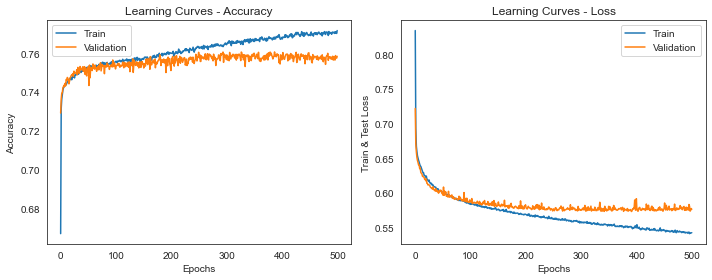

In [30]:
model_2 = Sequential()

model_2.add(Dense(64, activation='relu', name='m2_hidden1' ,input_dim=7))
model_2.add(Dense(64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(32, activation='relu', name='m2_hidden3'))
model_2.add(Dense(16, activation='relu', name='m2_hidden4'))
model_2.add(Dense(3, activation='softmax', name='m2_output'))

model_2.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

#hyperparameters for model 2
batch_size_model2 = 1000
m2_epochs = 500

#Training Second ANN Model 
history_2=model_2.fit(x_train, 
                      y_train_ann, 
                      batch_size=batch_size_model2, 
                      epochs=m2_epochs, 
                      verbose=0, 
                      validation_data=(X_val, y_val))

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Set the figure size and subplot layout

# Plotting the learning curves for train and test accuracy
axes[0].plot(history_2.history['accuracy'], label='Train')
axes[0].plot(history_2.history['val_accuracy'], label='Validation')
axes[0].set(xlabel='Epochs', ylabel='Accuracy', title='Learning Curves - Accuracy')
axes[0].legend()

# Plotting the learning curves for train and test loss
axes[1].plot(history_2.history['loss'], label='Train')
axes[1].plot(history_2.history['val_loss'], label='Validation')
axes[1].set(xlabel='Epochs', ylabel='Train & Test Loss', title='Learning Curves - Loss')
axes[1].legend()

plt.tight_layout()  # To ensure the plots don't overlap
plt.show()

### Third ANN Model

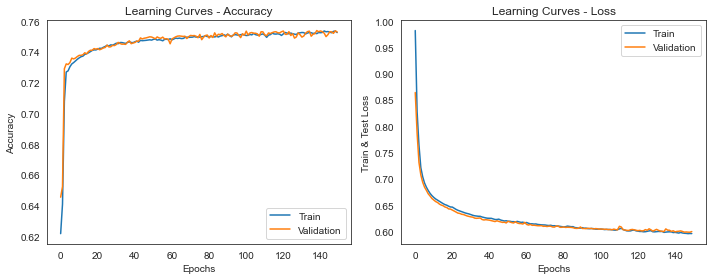

In [31]:
model_3 = Sequential()
model_3.add(Dense(128, activation='relu', name='m3_hidden1', input_dim=7))
model_3.add(Dense(64, activation='relu', name='m3_hidden2'))
model_3.add(Dense(32, activation='relu', name='m3_hidden3'))
model_3.add(Dense(3, activation='softmax', name='m3_output'))

model_3.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

#hyperparameters for model 3
batch_size_model3 = 5000
m3_epochs = 150

#Training Third ANN Model
history_3=model_3.fit(x_train, 
                      y_train_ann, 
                      batch_size=batch_size_model3, 
                      epochs=m3_epochs, 
                      verbose=0, 
                      validation_data=(X_val, y_val))

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Set the figure size and subplot layout

# Plotting the learning curves for train and test accuracy
axes[0].plot(history_3.history['accuracy'], label='Train')
axes[0].plot(history_3.history['val_accuracy'], label='Validation')
axes[0].set(xlabel='Epochs', ylabel='Accuracy', title='Learning Curves - Accuracy')
axes[0].legend()

# Plotting the learning curves for train and test loss
axes[1].plot(history_3.history['loss'], label='Train')
axes[1].plot(history_3.history['val_loss'], label='Validation')
axes[1].set(xlabel='Epochs', ylabel='Train & Test Loss', title='Learning Curves - Loss')
axes[1].legend()

plt.tight_layout()  # To ensure the plots don't overlap
plt.show()

### Comparison of All Three ANN Models:

426/426 [==============================] - 2s 3ms/step


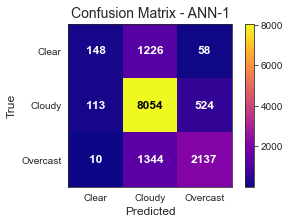

	Recall Score    : 54.74%
	Precision Score : 69.67%
	F1 Score        : 61.31%



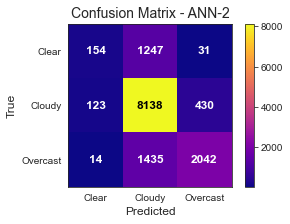

	Recall Score    : 54.29%
	Precision Score : 69.91%
	F1 Score        : 61.12%



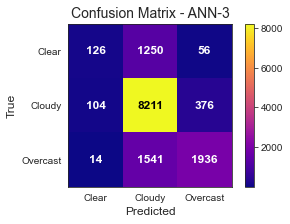

	Recall Score    : 52.91%
	Precision Score : 69.34%
	F1 Score        : 60.02%



In [32]:
# Predictions and Confusion Matrices
predictions = [np.argmax(model.predict(X_test), axis=1) for model in [model_1, model_2, model_3]]
confusion_matrices = [confusion_matrix(y_true=y_test_encoded, y_pred=pred) for pred in predictions]
models = ['ANN-1', 'ANN-2', 'ANN-3']
for model, cm in zip(models, confusion_matrices):
    plt.figure(figsize=(5, 3))
    plt.imshow(cm, interpolation='nearest', cmap='plasma')
    plt.title(f'Confusion Matrix - {model}', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test))
    plt.yticks(tick_marks, np.unique(y_test))
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            text_color = 'black' if cm[i, j] > cm.max() / 2 else 'white'
            plt.text(j, i, cm[i, j], ha='center', va='center', color=text_color, fontsize=12, weight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.show()

    avg_recall = np.mean(np.diag(cm) / np.sum(cm, axis=1))  # Recall Score
    avg_precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))  # Precision Score
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)  # F1 Score

    print('\tRecall Score    : {:.2%}'.format(avg_recall))
    print('\tPrecision Score : {:.2%}'.format(avg_precision))
    print('\tF1 Score        : {:.2%}'.format(f1_score))
    print('')

# Some Other Models
### Naive Bayes (MultinomialNB, GaussianNB):
It is a probabilistic algorithm based on Bayes' theorem. It assumes that features are conditionally independent given the class label. Naive Bayes is simple and efficient.

Naive Bayes is a simple yet powerful machine learning algorithm that is commonly used for classification tasks.

### Support Vector Machine:
SVM (Support Vector Machine) is a non-parametric machine learning algorithm. Non-parametric algorithms do not make strong assumptions about the underlying data distribution or the number of parameters needed to represent it.

In SVM, the goal is to find the hyperplane that maximizes the margin between different classes while minimizing the classification error. The number of support vectors, which are the data points closest to the decision boundary, determines the number of parameters needed to represent the model.

In [33]:
# Create an instance of Naive Bayes with alpha=0.5
nb = MultinomialNB(alpha=0.5)
nb.fit(X_train, y_train)
nb_train_predictions = nb.predict(X_train)
nb_test_predictions = nb.predict(X_test)
# Evaluate the accuracy of the model on training data
nb_train_accuracy = accuracy_score(y_train, nb_train_predictions)
nb_test_accuracy = accuracy_score(y_test, nb_test_predictions)
print(f'Naive Bayes (alpha=0.5) Train Accuracy: {nb_train_accuracy:0.1%}')
print(f'Naive Bayes (alpha=0.5) Test Accuracy: {nb_test_accuracy:0.1%}')


# Create an instance of Gaussian Naive Bayes with var_smoothing=0.1
gnb = GaussianNB(var_smoothing=0.1)
gnb.fit(X_train, y_train)
gnb_train_predictions = gnb.predict(X_train)
gnb_test_predictions = gnb.predict(X_test)
gnb_train_accuracy = accuracy_score(y_train, gnb_train_predictions)
gnb_test_accuracy = accuracy_score(y_test, gnb_test_predictions)
print(f'Gaussian Naive Bayes (var_smoothing=0.1) Train Accuracy: {gnb_train_accuracy:0.1%}')
print(f'Gaussian Naive Bayes (var_smoothing=0.1) Test Accuracy: {gnb_test_accuracy:0.1%}')
print("")
# Create an instance of SVM with C=0.1 and kernel='linear'
svm = SVC(C=0.1, kernel='linear')
svm.fit(X_train, y_train)
svm_train_predictions = svm.predict(X_train)
svm_test_predictions = svm.predict(X_test)

# Evaluate the accuracy of the model on training data
svm_train_accuracy = accuracy_score(y_train, svm_train_predictions)
svm_test_accuracy = accuracy_score(y_test, svm_test_predictions)
print(f'SVM (C=0.1, linear kernel) Train Accuracy: {svm_train_accuracy:0.1%}')
print(f'SVM (C=0.1, linear kernel) Test Accuracy: {svm_test_accuracy:0.1%}')

Naive Bayes (alpha=0.5) Train Accuracy: 64.2%
Naive Bayes (alpha=0.5) Test Accuracy: 63.8%
Gaussian Naive Bayes (var_smoothing=0.1) Train Accuracy: 70.5%
Gaussian Naive Bayes (var_smoothing=0.1) Test Accuracy: 70.5%

SVM (C=0.1, linear kernel) Train Accuracy: 73.0%
SVM (C=0.1, linear kernel) Test Accuracy: 73.0%


#                             User Interface

In [34]:
def UserInterface():
    print("*************** Welcome To The Weather Predictor... ***************\n")

    print('''The Weather Predictor is a Python script designed to predict the weather summary based on various weather features using machine learning models. The user can choose from three different models: K-Nearest Neighbors (KNN), Logistic Regression, and Artificial Neural Network (ANN). The provided features include temperature, humidity, windspeed, wind bearing, visibility, pressure, and month. ''')

    number_of_model=int(input("Choose Model: \n\t 1.KNN \n\t 2.Logistic Regression \n\t 3.ANN \nEnter No. of Model: "))
    f1=float(input('Temperature  -12.0 to 36.0    : '))
    f2=float(input('Humidity     0.2   to 1.0     : '))
    f3=float(input('Windspeed    0.0   to 30.0    : '))
    f4=float(input('Wind Bearing 0.0   to 351.0   : '))
    f5=float(input('Visibility   0.0   to 16.0    : '))
    f6=float(input('Pressure     985.0 to 1040.0  : '))
    f7=float(input('Month        1     to 12      : '))

    ''' A helper function to normalize a given value x between the specified min_value and max_value. 
        The function returns the normalized value in the range [0, 1].'''

    def normalize_value(x, min_value, max_value): # Normalizing the value in between 0 and 1.
        normalized_value = (x - min_value) / (max_value - min_value)
        return normalized_value

    # Creating a float_array to store normalized features
    float_array=[normalize_value(f1,-12.0,36.27), 
             normalize_value(f2,0.22,1), 
             normalize_value(f3,0.0,30.0),
             normalize_value(f4,0.0,351.0),
             normalize_value(f5,0.0,16.1),
             normalize_value(f6,985.0,1040.0),
             normalize_value(f7,1,12)]

    if number_of_model==1:
        prediction=knn2.predict([float_array]) # KNN 3rd Model
        print('The predicted Summary is: ',prediction)
        
    elif number_of_model==2:
        prediction=logreg3.predict([float_array]) # Logistic Regression
        print('The predicted Summary is: ',prediction)
        
    elif number_of_model==3:
        prediction=model_2.predict([float_array]) # Second ANN Model
        # Here we decoding back the class labels.
        decoded_predictions = [class_label_mapping[np.argmax(prediction)] for prediction in prediction]
        decoded_true_labels = [class_label_mapping[label] for label in y_test_encoded]
        # ANN gives probabilities
        print('The predicted Summary is: ',decoded_predictions)
        
    else:
        print('Error! Please Enter choose any number from the given options!')

In [35]:
UserInterface()

*************** Welcome To The Weather Predictor... ***************

The Weather Predictor is a Python script designed to predict the weather summary based on various weather features using machine learning models. The user can choose from three different models: K-Nearest Neighbors (KNN), Logistic Regression, and Artificial Neural Network (ANN). The provided features include temperature, humidity, windspeed, wind bearing, visibility, pressure, and month. 
Choose Model: 
	 1.KNN 
	 2.Logistic Regression 
	 3.ANN 
Enter No. of Model: 3
Temperature  -12.0 to 36.0    : 2.65526
Humidity     0.2   to 1.0     : 0.96
Windspeed    0.0   to 30.0    : 1.6100
Wind Bearing 0.0   to 351.0   : 96
Visibility   0.0   to 16.0    : 0.16
Pressure     985.0 to 1040.0  : 1027.73
Month        1     to 12      : 11
1/1 [==============================] - 0s 205ms/step
The predicted Summary is:  ['Overcast']
